In [3]:
# imports
import os
# import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from dotenv import load_dotenv
from gymnasium import spaces
import matplotlib.patches as patches
import shutil
import sumo_rl

# imports
SUMO_HOME = 'C:\\Program Files (x86)\\Eclipse\\Sumo'

os.environ['SUMO_HOME'] = SUMO_HOME

# Print the SUMO_HOME environment variable to verify
print("SUMO_HOME is set to:", os.environ.get('SUMO_HOME'))

# Check if the SUMO_HOME path exists
print("Does SUMO_HOME exist?", os.path.exists(os.environ.get('SUMO_HOME')))


# Define file paths
net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'
config_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.sumocfg'





SUMO_HOME is set to: C:\Program Files (x86)\Eclipse\Sumo
Does SUMO_HOME exist? True


# Environment

In [1]:
class Environment:
    def __init__(self, env_name, route_file, net_file, out_csv_name, render_mode='human', num_seconds=100000):
        self.env_name = env_name
        self.use_gui = True if render_mode == 'human' else False
        self.route_file = route_file
        self.net_file = net_file
        self.out_csv_name = out_csv_name
        self.env = gym.make(
                        env_name,
                        net_file=net_file,
                        route_file=route_file,
                        out_csv_name=out_csv_name,
                        use_gui=self.use_gui,
                        num_seconds=num_seconds
                    )
     
        self.state, _ = self.env.reset()
        self.done = False
        self.observation_space = self.env.observation_space.shape[0]
        self.action_space = self.env.action_space
        self.traffic_signals = self.env.traffic_signals
    
    def reset(self):
        self.state, _ = self.env.reset()
        self.done = False
        return self.state
    
    def custom_reward(self, traffic_signal, reward_type='average_speed', reward_method='simple'):
        # print("Inside custom reward method")
        if reward_method == 'simple':
            match reward_type:
                case 'average_speed':
                    return traffic_signal.get_avgerage_speed()
                case 'congesion':
                    return -1 * traffic_signal.get_pressure()
                case 'emissions':
                    return -1* traffic_signal.get_emission_co2()
                case 'throughput':
                    return traffic_signal.get_throughput()

        else:
            # Weighted sum of the metrics
            reward = 0
            if weights is None:
                weights = {
                    'average_speed': 0.4,
                    'waiting_time': 0.3,
                    'emissions': 0.2,
                    'throughput': 0.1
                }

            # Calculate individual rewards
            average_speed = traffic_signal.get_average_speed()
            waiting_time = -1* traffic_signal._diff_waiting_time_reward()
            total_queue = -1 * traffic_signal.get_total_queued()
            congesion = traffic_signal.get_pressure()

            print(average_speed, waiting_time, total_queue, congesion)
            weighted_reward = (
                weights['average_speed'] * average_speed +
                weights['waiting_time'] * waiting_time +
                weights['emissions'] * total_queue +
                weights['throughput'] * congesion
            )

            return weighted_reward
            
            
    def step(self, action):
        # print("Inside step method")
        next_state, reward, terminated, truncated, info = self.env.step(action)
        # print("Step taken", next_state, terminated, truncated, info)

        # print("Traffic signals:", list(self.traffic_signals.values())[0])
        # traffic_signal = list(self.traffic_signals.values())[0]
        # print("Pressure:", traffic_signal.get_pressure())
        # # print(traffic_signal.get_average_speed(), traffic_signal.get_total_queued(), traffic_signal._diff_waiting_time_reward(), traffic_signal.get_pressure())
        # reward = self.custom_reward(traffic_signal, reward_type='congesion', reward_method='simple')
        # print("Reward:", reward)

        self.state = next_state
        self.done = terminated
        return next_state, reward, self.done or truncated
    
    def render(self):
        self.env.render()
    
    def close(self):
        try:
            self.env.close()
            if traci.isLoaded():
                traci.close()
            print("Env and Traci closed successfully.")
        except Exception as e:
            print("Error while closing the environment:", e)
    
    def get_state(self):
        return self.state


## Random Agent Running (Testing)

In [ ]:
# Define paths to the network and route files (Buffalo Road Intersection)

# net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
# route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
# out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'


# Using Custom simple Traffic Intersection
nets_dir = 'nets'

file_name = 'single_intersection_simple'
out_csv_name = f'{file_name}.csv'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir, f'{file_name}.csv')

file_exists = lambda file_path: os.path.exists(file_path)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")


# Instantiate the environment
sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=100000)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space.n)
print("Initial State:", sumo_env.state)

max_steps = 10

try:
    print("action space", sumo_env.action_space)
    for step in range(max_steps):
        # sumo_env.render()
        action = sumo_env.env.action_space.sample()
        next_state, reward, done = sumo_env.step(action)
        print("Action ", action, " Reward ", reward, " Done ", done, "observation", next_state)
        
        if done:
            sumo_env.reset()
            break

except KeyboardInterrupt:
    print("Keyboard interrupt detected. Closing the environment.")

except Exception as e:
    print("Error occurred:", e)

finally:
    sumo_env.close()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.traffic_signals to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.traffic_signals` for environment variables or `env.get_wrapper_attr('traffic_signals')` that will search the reminding wrappers.
  logger.warn(


Observation Space: 11
Action Space: 2
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action space Discrete(2)
Action  0  Reward  0.0  Done  False observation [1.         0.         0.         0.1009761  0.1009761  0.10567101
 0.10567101 0.         0.         0.         0.        ]
Action  1  Reward  0.0  Done  False observation [1.         0.         1.         0.15146415 0.1009761  0.21134202
 0.15850651 0.         0.         0.         0.        ]
Action  1  Reward  -0.01  Done  False observation [0.         1.         0.         0.15146415 0.15146415 0.10567101
 0.10567101 0.05048805 0.         0.         0.        ]
Action  0  Reward  -0.13  Done  False observation [0.         1.         1.         0.15146415 0.15146415 0.10567101
 0.10567101 0.1009761  0.1009761  0.         0.        ]
Action  1  Reward  -0.24  Done  False observation [0.         1.         1.         0.2019522  0.15146415 0.10567101
 0.05283551 0.15146415 0.15146415 0.         0.        ]
Action  0  Reward  0.

# A3C Training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Observation Space: 11
Action Space: Discrete(2)
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training started...


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.traffic_signals to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.traffic_signals` for environment variables or `env.get_wrapper_attr('traffic_signals')` that will search the reminding wrappers.
  logger.warn(


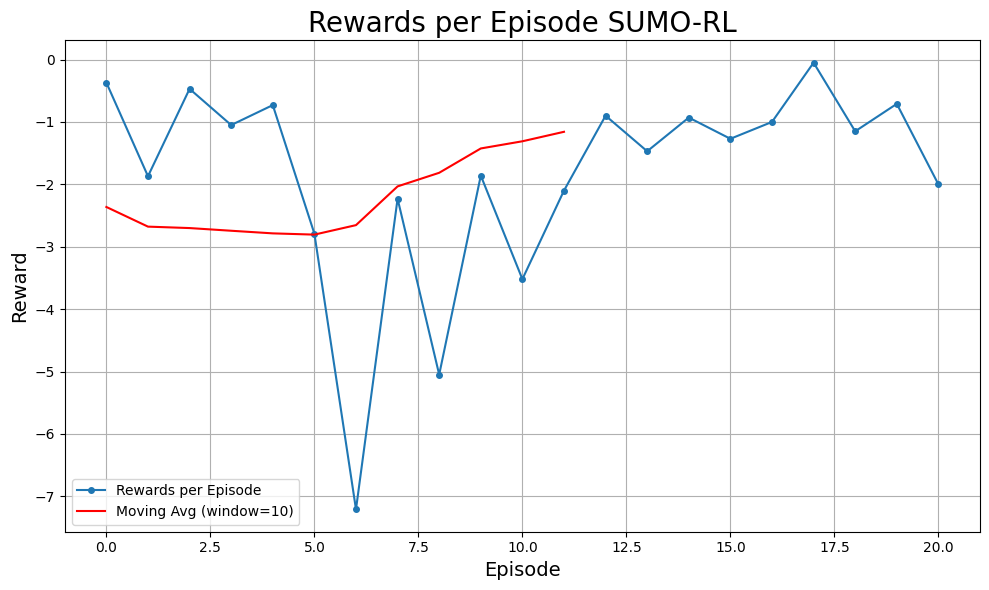

Error during cleanup: 'NoneType' object has no attribute 'close'


<ListProxy object, typeid 'list' at 0x26b6d06f7f0>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from a3c_sumo import train_a3c


n_episodes = 1000
learning_rate = 1e-3
C = 10
num_seconds = 500

nets_dir = 'nets'

file_name = 'single_intersection_simple'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir+"/a3c_results_csv", f'{file_name}.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'a3c_results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")

sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space)
print("Initial State:", sumo_env.state)

# max_steps = 1000

input_dims = sumo_env.observation_space
actions = sumo_env.action_space.n

# Pack all file related variables into a dictionary
file_paths = {
    'nets_file': nets_file,
    'routes_file': routes_file,
    'out_csv_name': out_csv_name
}


# Do not pass the environment object to the training function due to issues with pickling and locking
# Pass None instead

# Train the models
# train_a3c(sumo_env, max_steps=1000, num_episodes=10, gamma=0.99, lr=0.001, beta=0.01, num_processes=4)
train_a3c(None, input_dims=[input_dims], n_actions=actions, n_episodes=n_episodes, use_wandb=False, 
          grad_clip=10, C=10, env_id='SUMO-RL', lr=1e-4, input_files=file_paths)